In [1]:
# Get FTIR spectra from files
import sys
sys.path.append("..")
from toolkit.ascfile import read_asc
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import basename
from tqdm import tqdm
from toolkit.dataset import load_spectral_data, dataset_dict_to_dense

In [2]:
dataset_dict = load_spectral_data([
    "../raw_data/DataHenry23/Perkin/New_*/*.asc",
    "../raw_data/DataJulie/07_09_spectro/**/*.asc",
    "../raw_data/DataDavid/UVVIS/*.asc",
    "../raw_data/DataJulie/11_09_2023_angel/*.asc",
], verbose=True)
X, Y = dataset_dict_to_dense(dataset_dict)
print(X.shape, Y.shape)

Loading 360 files from ../raw_data/DataHenry23/Perkin/New_*/*.asc
Loading 43 files from ../raw_data/DataJulie/07_09_spectro/**/*.asc
Loading 115 files from ../raw_data/DataDavid/UVVIS/*.asc
Loading 16 files from ../raw_data/DataJulie/11_09_2023_angel/*.asc
(534, 226) (534, 6)


In [85]:
data = []
for i,f in enumerate(tqdm(perkin_files)):
    match = False
    b1 = basename(f.replace(".Sample.Raw", "").replace(".asc", ".ASC"))
    if "9S" in b1:
        print("skipping old")
        continue
    perkin_data = read_asc(f)
    data.append((perkin_data[1], b1))
print(f"Data size: {len(data)}")

Perkin files: 522


  0%|          | 0/522 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 5655.27it/s]

skipping old
skipping old
skipping old
skipping old
Data size: 518


In [86]:
old_perkin = glob("../raw_data/DataHenry23/Perkin/Ancien_Parcht_Perkin/*.asc", recursive=True)
old_perkin_samples = list()
for f in old_perkin:
    lamb, refl = read_asc(f)
    old_perkin_samples.append(refl)
old_perkin_samples= np.asarray(old_perkin_samples)

In [176]:
dshape = len(data), data[0][0].shape[-1]#+ #data[0][1][::1].shape[-1]
species = { "C": 0, "S": 1, "G": 2}
type = { "C": 0, "F": 1, "X": 2}
location = { "H10": 0, "N10": 1, "XXX": 2}
X = np.zeros(dshape)
Y = np.zeros((dshape[0], 6), dtype=np.uint32)
for i, (perkin, fname) in enumerate(data):
    X[i, :] = perkin # np.hstack((perkin, ftir[::1]))
    Y[i, 0] = int(fname[0:3])      # Skin
    Y[i, 1] = species[fname[5]]      # Espèce
    Y[i, 2] = int(fname[4])          # Process step
    Y[i, 3] = location[fname[7:10]]   # Location
    Y[i, 4] = type[fname[11:12]]       # Grain / Flesh
    Y[i, 5] = int(fname[12:15])       # ID
    if fname[7:10] not in location.keys():
        print("ERROR")
    if fname[11:12] not in type.keys():
        print("ERROR")
    if fname[5] not in species.keys():
        print("ERROR")
        
np.savez_compressed("dataset.npz", X=X, Y=Y)

In [88]:
#ftir_max = np.max(X[:, 226:], axis=1)
#X[:, 226:] /= ftir_max.reshape(ftir_max.shape[0], 1)
perkin_max = np.max(X[:, :], axis=1)
X /= perkin_max.reshape(X.shape[0], 1)
perkin_max = np.max(old_perkin_samples[:, :], axis=1)
old_perkin_samples /= perkin_max.reshape(old_perkin_samples.shape[0], 1)
X = X[Y[:,5]< 20,:]
Y = Y[Y[:,5]< 20,:]

In [139]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(in_features, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, out_features)

    def forward(self, X, return_antelatent=False):
        X = torch.tanh(self.l1(X))
        X1 = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(X1))
        if not return_antelatent:
            return X
        else:
            return X, X1

class Decoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(in_features, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, out_features)

    def forward(self, X):
        X = torch.tanh(self.l1(X))
        X = torch.relu(self.l2(X))
        X = self.l3(X)
        return X

class AutoEncoder(nn.Module):
    def __init__(self, features, latent_features=2, variationnal=False, smoothing=15):
        super(AutoEncoder, self).__init__()
        if variationnal:
            self.enc = Encoder(features, latent_features*2)
            self.dec = Decoder(latent_features, features+smoothing-1)
        else:
            self.enc = Encoder(features, latent_features)
            self.dec = Decoder(latent_features, features+smoothing-1)

        self.latent_features = latent_features
        self.variationnal = variationnal
        self.smoothing = smoothing
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=self.smoothing)
        self.classification = nn.Linear(64, 3)
    def forward(self, X, return_classif=False):
        bs = X.shape[0]
        if self.variationnal:
            if return_classif:
                X, X1 = self.enc(X, return_antelatent=True)
                X = X.view(-1, 2, self.latent_features)
                classif = torch.log_softmax(self.classification(X1), dim=1)
            else:
                X = self.enc(X).view(-1, 2, self.latent_features)
            mu = X[:, 0, :]
            logvar = (X[:, 1, :] - 1) * 5
            X = self.reparameterize(mu, logvar)
            if return_classif:
                return self.c1(self.dec(X).view(bs, 1, -1)).view(bs, -1), mu, logvar, classif
            else:
                return self.c1(self.dec(X).view(bs, 1, -1)).view(bs, -1), mu, logvar
        else:
            return self.c1(self.dec(self.enc(X)).view(bs, 1, -1)).view(bs, -1)
    
    def reconstruct(self, X):
        bs = X.shape[0]
        recons = self.dec(X).view(bs, 1, -1)
        recons = self.c1(recons)
        return (recons.view(bs, -1))
    
    def encode(self, X, std=False):
        code = self.enc(X)
        if self.variationnal:
            view = code.view(-1, 2, self.latent_features)
            if std:
                return view[:, 0, :], view[:, 1, :]
            else:
                return view[:, 0, :]
        else:
            return self.enc(X)

    def reparameterize(self, latent_mean, latent_logvar):
        std = torch.exp(0.5*latent_logvar)
        eps = torch.randn_like(std)
        sample = latent_mean + (eps * std)
        return sample

In [177]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(ae))


62023


In [140]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

#from toolkit.preprocessing import MeanMinMaxScaler
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
ops = scaler.transform(old_perkin_samples)
#Xs = X.copy()
loader = DataLoader(TensorDataset(torch.from_numpy(Xs).type(torch.float), torch.from_numpy(Y[:,1].astype(np.int32)).type(torch.long)), batch_size=8, shuffle=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.058658322701469444: 100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s]


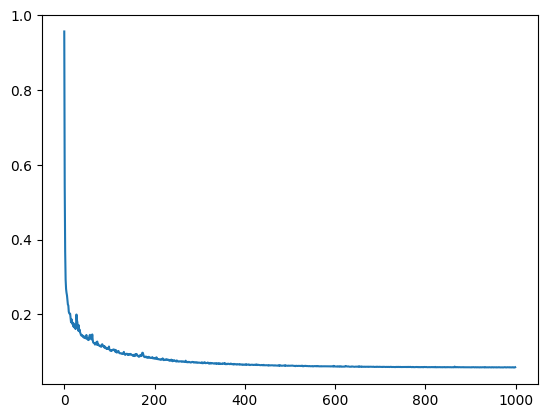

In [175]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam
from tqdm import trange

ae = AutoEncoder(Xs.shape[1], 2, variationnal=True, smoothing=15)
optim = Adam(ae.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = StepLR(optim, step_size=10, gamma=0.95)

mse_loss = nn.MSELoss()
nll_loss = nn.NLLLoss()
losses = list()

num_epochs = 1000
progress_bar = trange(num_epochs)
for epoch in progress_bar:
    epoch_loss = 0.0
    for X_real, Y_real in loader:
        bs = X_real.shape[0]
        optim.zero_grad()
        X_a = X_real.clone()
        #X_a[:, 165:] *= 0.9 + np.random.rand(bs, 1) * 0.2
        #X_a[:, :] = torch.from_numpy(scaler.transform(scaler.inverse_transform(X_a) * (0.7 + 0.6 * np.random.rand(bs, 1))))
        X_noisy = X_a + torch.randn(bs, X_a.shape[1]) * 0.1
        Xp, mu, logvar, classif = ae(X_noisy, return_classif=True)
        logvar[:] = logvar * 0 + np.log(0.1)
        recons_loss = mse_loss(Xp, X_a)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        classif_loss = nll_loss(classif, Y_real)
        (recons_loss+kld_loss*1e-4+classif_loss).backward()
        optim.step()
        epoch_loss += recons_loss.item()
    scheduler.step()
    epoch_loss /= len(loader)
    losses.append(epoch_loss)
    progress_bar.set_description_str(f"{epoch_loss}")
plt.plot(losses)

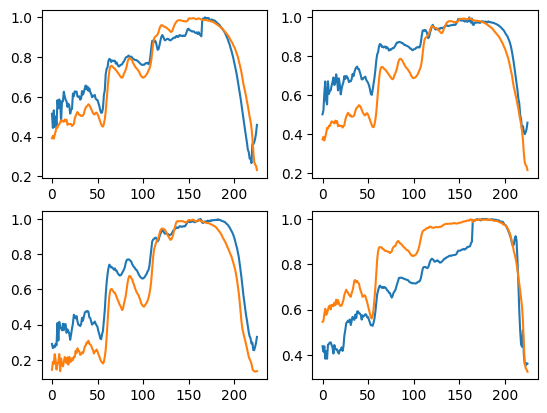

In [142]:
fig, axs = plt.subplots(2,2)
axs= axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(scaler.inverse_transform(ops[0:5])[i, :])
    opsr,_,_ = ae(torch.from_numpy(ops[0:5]).type(torch.float))
    opsr = opsr.detach().numpy()
    ax.plot(scaler.inverse_transform(Xp.detach().numpy())[i, :])

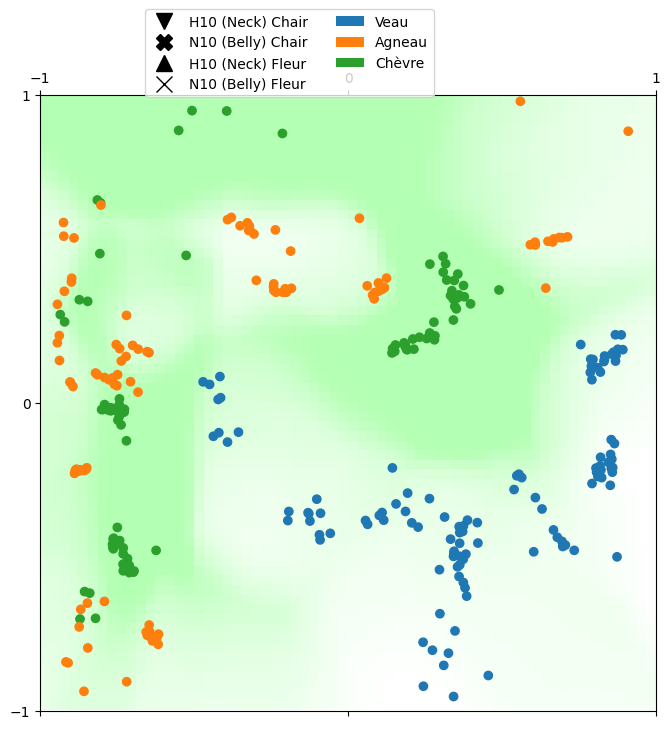

In [143]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
my_cmapr = ListedColormap([(1.0, 0.0,0.0, i/255) for i in range(255)])
my_cmapg = ListedColormap([(0.0, 1.0,0.0, i/255) for i in range(255)])
my_cmapb = ListedColormap([(0.0, 0.0,1.0, i/255) for i in range(255)])

latent = ae.encode(torch.from_numpy(Xs).type(torch.float)).detach().numpy()
latent_old = ae.encode(torch.from_numpy(ops).type(torch.float)).detach().numpy()
_, _ , _, classif_old = ae(torch.from_numpy(ops).type(torch.float), return_classif=True)
classif_old = np.argmax(classif_old.detach().numpy(), axis=1)
if True:
    x = np.linspace(-1, 1, 64)
    XX, YY = np.meshgrid(x,x)
    XY = np.vstack((XX.flat, YY.flat)).T
    spectres = ae.reconstruct(torch.from_numpy(XY).type(torch.float))
    _, _, _, classif = ae(spectres, return_classif=True)
    classif = classif.detach().numpy()

markers = ["v", "X", "^", "x"]
fig, ax = plt.subplots(figsize=(8,8))
if True:         
    #ax.matshow((classif.reshape(64,64, 3)[:,:,0]), origin="lower", extent=[-1,1,-1,1], cmap=my_cmapb, alpha=0.3)  
    #ax.matshow((classif.reshape(64,64, 3)[:,:,1]), origin="lower", extent=[-1,1,-1,1], cmap=my_cmapr,  alpha=0.3)  
    ax.matshow((classif.reshape(64,64, 3)[:,:,2]), origin="lower", extent=[-1,1,-1,1], cmap=my_cmapg, alpha=0.3)  
#markerlabel = np.array([ a  + b * 10 + c*100 for a, b, c in zip( Y[:, 1], Y[:, 2], Y[:, 3])]) # Process, Location, Side
#for i, c in enumerate(np.unique(markerlabel)):
#    print(markers[i], "=", c)
#    mask = markerlabel == c
#    cur = latent[mask,:]
legend_elements = [Line2D([0], [0], marker="v", markersize=12, color='k', linestyle="", label='H10 (Neck) Chair'),
                   Line2D([0], [0], marker="X", markersize=12, color='k', linestyle="", label='N10 (Belly) Chair'),
                   Line2D([0], [0], marker='^', color='k', linestyle="", label='H10 (Neck) Fleur', markersize=12),
                   Line2D([0], [0], marker='x', color='k', linestyle="", label='N10 (Belly) Fleur', markersize=12),
                   Patch(facecolor='C0',  label='Veau'),
                   Patch(facecolor='C1',  label='Agneau'),
                   Patch(facecolor='C2',  label='Chèvre'),
                   ]
#ax.scatter(*latent_old.T, c=[f"C{i}" for i in classif_old ], marker="x", s=100)
ax.scatter(*latent.T, c=[f"C{l}" for l in Y[:, 1].flat])#, marker=markers[i], s=100)
plt.axis("square")
plt.axis([-1, 1, -1, 1])
plt.legend(handles=legend_elements, bbox_to_anchor =(0.65, 1.15), ncol=2)

In [159]:
correct = np.count_nonzero(classif_old==1)
print("Accuracy on unseen historical parchments = ", correct/classif_old.shape[0])
_,_,_,preds_cls = ae(torch.from_numpy(Xs).type(torch.float), return_classif=True)
classif_new = np.argmax(preds_cls.detach().numpy(), axis=1)
correct = np.count_nonzero(classif_new==Y[:,1])
print("Accuracy on training set = ", correct/classif_new.shape[0])

Accuracy on unseen historical parchments =  0.975
Accuracy on training set =  1.0


In [ ]:
for i, file in enumerate(perkin_files):
    plt.plot(*read_asc(file), alpha=0.1, color="red")


x,y = read_asc(file)
print(x.shape)
plt.axvline(x[165])
    

In [ ]:
#for i, file in enumerate(perkin_files[4:6]):
#    plt.plot(*read_asc(file), alpha=0.8, color="red")

x, p1 = read_asc(perkin_files[4])
x, p2 = read_asc(perkin_files[5])
mm = 163
plt.plot(x[mm:], p1[mm:]+2, alpha=0.8, color="red")
#plt.plot(x, p2, alpha=0.8, color="black")

#plt.axvline(860)
#plt.axvline(729)



In [ ]:
perkin_files[4:6]

In [ ]:
data = read_asc("../blanc_20minchauffe.Sample.asc")
plt.plot(*data)

In [39]:
# let's shap !
import shap
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, ae):
        super(Classifier, self).__init__()
        self.ae = ae
        
    def forward(self, X):
        _,_,_,classif = self.ae(X, return_classif=True)
        return classif

classif_model = Classifier(ae)
batch = torch.from_numpy(Xs).type(torch.float)
idx = torch.randperm(batch.shape[0])
batch[idx, :] = batch.clone()
background = batch[:]
test_images = batch[250:]

e = shap.DeepExplainer(classif_model, background)
shap_values = e.shap_values(test_images)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [117]:
shap_values[0].shape
shap_values = np.asarray(shap_values).copy()
print(Xs.shape)
#shap_values[shap_values>0] = np.exp(shap_values[shap_values>0])
#mask = shap_values<=0
#shap_values[mask] = -np.exp(-shap_values[mask])

#axs[2].set_ylim(-0.001, 0.001)
#axs[1].plot(np.mean((shap_values[0][:,:226]), axis=0))
#axs[1].plot(np.mean((shap_values[1][:,:226]), axis=0))
#axs[1].plot(np.mean((shap_values[2][:,:226]), axis=0))

(309, 226)


(51, 226)


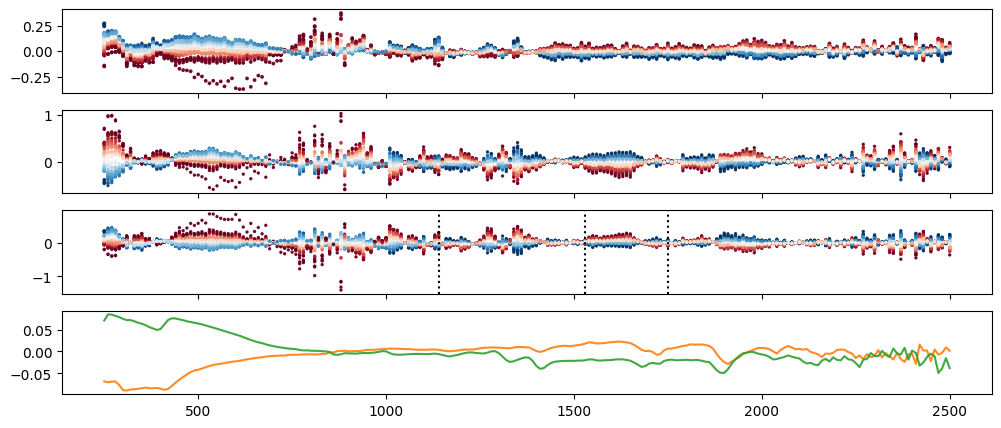

In [123]:
fig, axs = plt.subplots(4,1, figsize=(12,5), sharex=True, sharey=False)
size_ftir = shap_values[0].shape[-1]
x = np.flipud(np.linspace(250, 2500, 226))
print(shap_values[0].shape)
norm = plt.Normalize()
for i in range(len(shap_values[0])):
    colors = plt.cm.RdBu(norm(test_images[i,:]))
    axs[0].scatter(x, (shap_values[0][i,:]), alpha=0.9, c=colors, s=3)
for i in range(len(shap_values[1])):
    colors = plt.cm.RdBu(norm(test_images[i,:]))
    axs[1].scatter(x, shap_values[1][i,:], alpha=0.9, c=colors, s=2)
for i in range(len(shap_values[2])):
    colors = plt.cm.RdBu(norm(test_images[i,:]))
    axs[2].scatter(x, shap_values[2][i,:], alpha=0.9, c=colors, s=2)
#axs[2].bar(x, np.mean((shap_values[2][:,:]), axis=0), alpha=0.9, width=15, c=colors)
axs[3].plot(x, np.mean(X[Y[:,0]==0][:,:]-np.mean(X, axis=0), axis=0), alpha=0.9)
axs[3].plot(x, np.mean(X[Y[:,0]==1][:,:]-np.mean(X, axis=0), axis=0), alpha=0.9)
axs[3].plot(x, np.mean(X[Y[:,0]==2][:,:]-np.mean(X, axis=0), axis=0), alpha=0.9)
#axs[3].plot(x, np.mean(X, axis=0), "k:", alpha=0.9)
#axs[3].set_ylim(0, 1)
axs[2].axvline(1140, c='k', ls=":")
axs[2].axvline(1530, c='k', ls=":")
axs[2].axvline(1750, c='k', ls=":")

In [ ]:
perkin_files = glob("../raw_data/DataHenry23/Perkin/New*/*.asc", recursive=True)
for f in perkin_files:
    plt.plot(*read_asc(f), color="r", alpha=0.1)

In [ ]:
old = "/Users/kaeryv/prj/parchments2/raw_data/DataHenry23/Perkin/Ancien_Parcht_Perkin/S-11753-001.Sample.Raw.asc"
old = read_asc(old)
for f in perkin_files:
    plt.plot(*read_asc(f), color="r", alpha=0.1)
plt.plot(*old, c="k")

In [ ]:
old_perkin_files = glob("../raw_data/DataHenry23/Perkin/Ancien*/*.asc", recursive=True)
for f in perkin_files:
    plt.plot(*read_asc(f), color="r", alpha=0.1)
for old in old_perkin_files:
    old = read_asc(old)
    plt.plot(*old, c="k", alpha=0.1)
ok = [1,2,5]


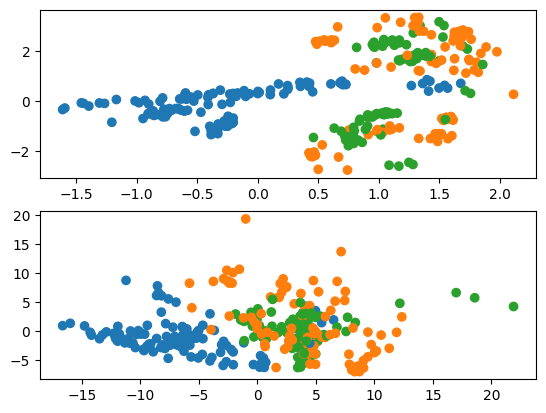

In [145]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
proj = TSNE(2, perplexity=200)
proj2 = PCA(3)
latent = proj.fit_transform(Xs)
latent2 = proj2.fit_transform(Xs)[:,1:3]
fig, (ax1,ax2) = plt.subplots(2, 1)
ax1.scatter(*latent.T, c=[f"C{i}" for i in Y[:,1]])
ax2.scatter(*latent2.T, c=[f"C{i}" for i in Y[:,1]])

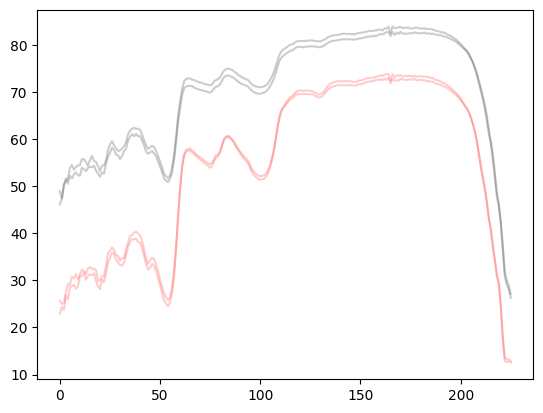

In [55]:
files_julie_r = glob("../raw_data/DataJulie/07_09_spectro/mouton/rase/*N10-C00*.asc")
files_julie_d = glob("../raw_data/DataJulie/07_09_spectro/mouton/duveteux/*N10-C00*.asc")
d_r = list()
d_d = list()
for file in files_julie_r:
    d_r.append(read_asc(file)[1])
for file in files_julie_d:
    d_d.append(read_asc(file)[1])

d_r = np.asarray(d_r)
d_d = np.asarray(d_d)
plt.figure()
plt.plot(d_r.T, color="r", alpha=0.2)
plt.plot(d_d.T, color="k", alpha=0.2)

In [ ]:
root_perkin = "../raw_data/DataHenry23/Perkin/New_*/*.asc"
perkin_files = glob(root_perkin, recursive=True)
perkin_files.extend(glob(root_perkin.replace(".asc", ".ASC"), recursive=True))
for file in perkin_files:
    os.rename(file, file.replace("3S-", "001-3S-").replace("3C-", "002-3C-").replace("3G-", "003-3G-"))

In [93]:
files_julie = glob("../raw_data/DataDavid/**/*.asc")
for file in files_julie:
    os.rename(file, file.replace("3C-", "007-3C-"))
print(files_julie)


['../raw_data/DataDavid/UVVIS/3C-XXX-F011.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C016.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C003.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C072.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C067.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-F019.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C004.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C011.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-F016.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C060.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C075.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C068.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C019.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C069.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C018.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-F017.Sample.Raw.asc', '../raw_data/DataDavid/UVVIS/3C-XXX-C010.Sample.Raw.asc', '../raw_data/

In [151]:
files_julie_r = glob("../raw_data/DataJulie/historique/*.asc")
print(len(files_julie_r))
d_r = list()
for file in files_julie_r:
    d_r.append(read_asc(file)[1])

d_r=np.asarray(d_r)
d_rmax = np.max(d_r, axis=1)
d_r /= d_rmax.reshape(d_r.shape[0], 1)
d_r = scaler.transform(d_r)

21


In [164]:
_, _, _, classif = ae(torch.from_numpy(d_r).type(torch.float), return_classif=True)

../raw_data/DataJulie/historique/msmeh8_side1_1.Sample.asc 1 [-1.24412365e+01 -4.41073416e-06 -1.44640198e+01]
../raw_data/DataJulie/historique/msmeh7_side2_1.Sample.asc 1 [-9.9941778e+00 -1.3112162e-04 -9.3678141e+00]
../raw_data/DataJulie/historique/msmeh8_side2_2.Sample.asc 1 [-9.8618097e+00 -5.2808322e-05 -1.4134477e+01]
../raw_data/DataJulie/historique/msmeh7_side1_2.Sample.asc 1 [-9.27332   -0.1306647 -2.1005092]
../raw_data/DataJulie/historique/Hull_1769_side2.Sample.asc 1 [-1.2506326e+01 -4.4821689e-05 -1.0099084e+01]
../raw_data/DataJulie/historique/Hull_1568_side1.Sample.asc 1 [-1.2436085e+01 -5.6980418e-05 -9.8453846e+00]
../raw_data/DataJulie/historique/Hull_1652_side1.Sample.asc 1 [-1.2248815e+01 -8.6460874e-04 -7.0592179e+00]
../raw_data/DataJulie/historique/mskat_side1_2.Sample.asc 1 [-7.9252806  -0.03215301 -3.4647717 ]
../raw_data/DataJulie/historique/Hull_1870_side2.Sample.asc 1 [-1.3866532e+01 -9.5367386e-07 -1.7587532e+01]
../raw_data/DataJulie/historique/mskat_side

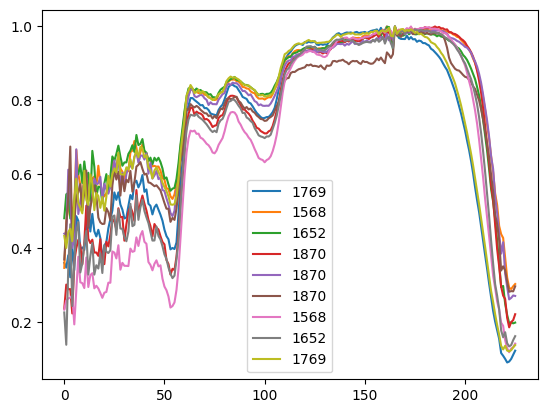

In [174]:
for file, clas, pond, spec in zip(files_julie_r, np.argmax(classif.detach(), axis=1), classif, scaler.inverse_transform(d_r)):
    print(file, clas.numpy(), pond.detach().numpy())
    if "Hull" in file:
        plt.plot(spec, label=os.path.basename(file).split("_")[1])
plt.legend()